In [67]:
print(__doc__)

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy  
from scipy import linalg

from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale  
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import itertools

from sklearn import mixture


style.use("ggplot")
%matplotlib inline



Automatically created module for IPython interactive environment


In [68]:
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

In [69]:
raw_data = pd.read_csv('C:/Users/Chenming/Desktop/assignment3/Data1_Car/car.csv')
#convert buying to int, 'vhigh'->0, 'high'->1,'med'->2,'low'->3, save to a new dataset: data 
raw_data['buying'] = raw_data.buying.str.replace('vhigh','0')
raw_data['buying'] = raw_data.buying.str.replace('high','1')
raw_data['buying'] = raw_data.buying.str.replace('med','2')
raw_data['buying'] = raw_data.buying.str.replace('low','3')
data=raw_data
data['buying']=raw_data.buying
data['buying']=data.buying.astype(int)

In [70]:
#convert maint to int, 'vhigh'->0, 'high'->1,'med'->2,'low'->3, save to a new dataset: data 
raw_data['maint'] = raw_data.maint.str.replace('vhigh','0')
raw_data['maint'] = raw_data.maint.str.replace('high','1')
raw_data['maint'] = raw_data.maint.str.replace('med','2')
raw_data['maint'] = raw_data.maint.str.replace('low','3')
data['maint']=raw_data.maint
data['maint']=data.maint.astype(int)

In [71]:
#convert doors, 5more ->5, all to int
raw_data['doors'] = raw_data.doors.str.replace('5more','5')
data['doors']=raw_data.doors
data['doors']=data.doors.astype(int)

In [72]:
#persons more->5, all to int
raw_data['persons'] = raw_data.persons.str.replace('more','5')
data['persons']=raw_data.persons
data['persons']=data.persons.astype(int)

In [73]:
#lug_boot, small->0, med->1, big->2, all to int
raw_data['lug_boot'] = raw_data.lug_boot.str.replace('small','0')
raw_data['lug_boot'] = raw_data.lug_boot.str.replace('med','1')
raw_data['lug_boot'] = raw_data.lug_boot.str.replace('big','2')
data['lug_boot']=raw_data.lug_boot
data['lug_boot']=data.lug_boot.astype(int)

In [74]:
#safety, low->0, med->1, high->2
raw_data['safety'] = raw_data.safety.str.replace('low','0')
raw_data['safety'] = raw_data.safety.str.replace('med','1')
raw_data['safety'] = raw_data.safety.str.replace('high','2')
data['safety']=raw_data.safety
data['safety']=data.safety.astype(int)

In [75]:
#set label column
data['acceptable_label'] = raw_data.acceptable

In [76]:
#acceptable, unacc->0, acc->1, good->2, vgood->3
raw_data['acceptable'] = raw_data.acceptable.str.replace('unacc','0')
raw_data['acceptable'] = raw_data.acceptable.str.replace('acc','1')
raw_data['acceptable'] = raw_data.acceptable.str.replace('good','2')
raw_data['acceptable'] = raw_data.acceptable.str.replace('v2','3')
data['acceptable']=raw_data.acceptable
data['acceptable']=data.acceptable.astype(int)
data.head()

,buying,maint,doors,persons,lug_boot,safety,acceptable,acceptable_label
0,0,0,2,2,0,0,0,unacc
1,0,0,2,2,0,1,0,unacc
2,0,0,2,2,0,2,0,unacc
3,0,0,2,2,1,0,0,unacc
4,0,0,2,2,1,1,0,unacc


In [77]:
datalist_label = data.acceptable
datalist_names = data.acceptable_label
datalist_label_names = np.array(['unacc','acc','good','vgood'])
datalist = data.drop(['acceptable','acceptable_label'], axis=1)
datalist_array = datalist.values
datalist_array

array([[0, 0, 2, 2, 0, 0],
       [0, 0, 2, 2, 0, 1],
       [0, 0, 2, 2, 0, 2],
       ..., 
       [3, 3, 5, 5, 2, 0],
       [3, 3, 5, 5, 2, 1],
       [3, 3, 5, 5, 2, 2]])

In [78]:
EM_data = data.drop(['buying','maint','doors','persons','lug_boot','safety'], axis=1)

In [79]:
#NN  on X = datalist_array, y = datalist_label
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.cross_validation import StratifiedKFold
import time
from sklearn.neural_network import MLPClassifier

skf = StratifiedKFold(datalist_label, n_folds=4)
# Only take the first fold.
train_index, test_index = next(iter(skf))


X_train = datalist_array[train_index]
y_train = datalist_label[train_index].values
X_test  = datalist_array[test_index]
y_test  = datalist_label[test_index].values

In [80]:
#implement rp on datalist
from sklearn import random_projection

In [81]:
# Compute RP
#  Higher values indicate a higher, sharper peak; lower values indicate a lower, less distinct peak
#if non-Fisher Kurtosis, nomral distribution is 3.  Closer to normal distribution is better for ML.
for i in range(1,6):
    rp = random_projection.GaussianRandomProjection(n_components = i)
    RP_ = rp.fit_transform(datalist)  # Reconstruct signals
    print ('component: ', i, ', Kurtosis: ', scipy.stats.kurtosis(RP_, fisher=False))

component:  1 , Kurtosis:  [ 2.46258258]
component:  2 , Kurtosis:  [ 2.63866227  2.63258975]
component:  3 , Kurtosis:  [ 2.3646274   2.39779451  2.6162382 ]
component:  4 , Kurtosis:  [ 2.14035765  1.60474964  2.62946985  2.43285412]
component:  5 , Kurtosis:  [ 2.60213349  2.1218704   2.48749526  2.49332007  2.51924804]


In [82]:
rp_gaussian = random_projection.GaussianRandomProjection(n_components = 2)
data_RP = rp_gaussian.fit_transform(datalist)

In [83]:
data_RP

array([[-2.33581822, -0.95945081],
       [-1.05558661, -0.09285068],
       [ 0.224645  ,  0.77374945],
       ..., 
       [-5.44700087, -2.0960773 ],
       [-4.16676926, -1.22947717],
       [-2.88653766, -0.36287704]])

In [84]:
#Try NN
#NN upon RP dataset
from sklearn.metrics import explained_variance_score

X_train = data_RP[train_index]
y_train = datalist_label[train_index].values
X_test  = data_RP[test_index]
y_test  = datalist_label[test_index].values

start_time = time.time()

mlp = MLPClassifier(hidden_layer_sizes=(50,10), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.03)

mlp.fit(X_train, y_train)
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)
elapsed_time = time.time() - start_time

print("Training set score: %f" % mlp.score(X_train, y_train))
print ("Training variance: ", explained_variance_score(y_train, y_train_pred, multioutput='uniform_average'))
print("Test set score: %f" % mlp.score(X_test, y_test))
print ("Testing variance: ", explained_variance_score(y_test, y_test_pred, multioutput='uniform_average'))
print ("Running Time: ", elapsed_time)

Iteration 1, loss = 1.18398165
Iteration 2, loss = 0.86916551
Iteration 3, loss = 0.82117248
Iteration 4, loss = 0.78969118
Iteration 5, loss = 0.77652014
Iteration 6, loss = 0.76502031
Iteration 7, loss = 0.75824803
Iteration 8, loss = 0.75505754
Iteration 9, loss = 0.75200683
Iteration 10, loss = 0.75030902
Iteration 11, loss = 0.74820749
Iteration 12, loss = 0.74742838
Iteration 13, loss = 0.74678883
Iteration 14, loss = 0.74680897
Iteration 15, loss = 0.74547633
Iteration 16, loss = 0.74376251
Iteration 17, loss = 0.74330592
Iteration 18, loss = 0.74360160
Iteration 19, loss = 0.74272358
Iteration 20, loss = 0.74055388
Iteration 21, loss = 0.73973505
Iteration 22, loss = 0.73914181
Iteration 23, loss = 0.73888179
Iteration 24, loss = 0.73750137
Iteration 25, loss = 0.74095135
Iteration 26, loss = 0.73635110
Iteration 27, loss = 0.73626543
Iteration 28, loss = 0.73760957
Iteration 29, loss = 0.73510759
Iteration 30, loss = 0.73553784
Iteration 31, loss = 0.73393828
Iteration 32, los

In [85]:
#EM, Try GMMs with K=4
new_component=4
cv_type='spherical'
gmm = mixture.GaussianMixture(n_components=new_component,
                                      covariance_type=cv_type)
gmm.fit(data_RP)
datalist_pred = gmm.predict(data_RP)

EM_data['K4_RP_label']=datalist_pred
K4_RP_label = datalist_pred
K4_RP_label

array([2, 2, 0, ..., 3, 1, 1], dtype=int64)

In [86]:
tb1 = pd.crosstab(EM_data['acceptable_label'],datalist_pred)
#data_label.head()
tb1

col_0,0,1,2,3
acceptable_label,,,,
acc,94,112,156,22
good,16,26,25,2
unacc,162,423,375,250
vgood,19,14,32,0


In [87]:
#EM assign test K=4 label
def em_K1_label(alpha):
    label_max = max(tb1.iloc[i,alpha] for i in range(4))
    if tb1.iloc[0,alpha] == label_max:
        return 'acc'
    if tb1.iloc[1,alpha] == label_max:
        return 'good'
    if tb1.iloc[2,alpha] == label_max:
        return 'unacc'
    if tb1.iloc[3,alpha] == label_max:
        return 'vgood'
EM_data['K4_RP_label_name']=EM_data['K4_RP_label'].apply(em_K1_label)
EM_data.head()

,acceptable,acceptable_label,K4_RP_label,K4_RP_label_name
0,0,unacc,2,unacc
1,0,unacc,2,unacc
2,0,unacc,0,unacc
3,0,unacc,2,unacc
4,0,unacc,2,unacc


In [88]:
K4_RP_accuracy = len(EM_data[EM_data['acceptable_label']==EM_data['K4_RP_label_name']])/len(EM_data)
print('K=4 RP EM -> {0:.4f}%'.format(K4_RP_accuracy*100))

K=4 RP EM -> 70.0231%


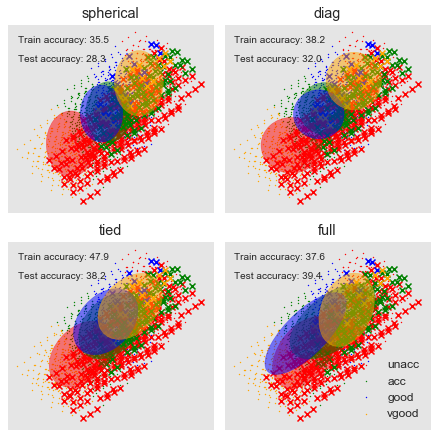

In [89]:
# Try GMMs using different types of covariances. K=4, iteration=200
n_classes=4
X_train = data_RP[train_index]
y_train = datalist_label[train_index]
X_test  = data_RP[test_index]
y_test  = datalist_label[test_index]
colors= ['red', 'green', 'blue', 'orange']
estimators = dict((cov_type, GaussianMixture(n_components=n_classes,
                   covariance_type=cov_type, max_iter=200, random_state=0))
                  for cov_type in ['spherical', 'diag', 'tied', 'full'])

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)
for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = data_RP[K4_RP_label == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=datalist_label_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

In [90]:
# EM K=14, full
new_component=14
cv_type='spherical'
gmm = mixture.GaussianMixture(n_components=new_component,
                                      covariance_type=cv_type)
gmm.fit(data_RP)
datalist_pred = gmm.predict(data_RP)

EM_data['K14_RP_label']=datalist_pred
K14_RP_label = datalist_pred

In [91]:
tb1 = pd.crosstab(EM_data['acceptable_label'],datalist_pred)
#data_label.head()
tb1

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13
acceptable_label,,,,,,,,,,,,,,
acc,41,23,22,43,45,43,19,38,0,34,20,49,0,7
good,9,0,5,8,7,13,5,10,0,1,0,11,0,0
unacc,54,37,88,98,150,37,160,45,83,112,115,106,71,54
vgood,7,1,0,13,14,8,0,14,0,2,1,5,0,0


In [92]:
#EM: assign test K=14 label

EM_data['K14_RP_label_name']=EM_data['K14_RP_label'].apply(em_K1_label)
EM_data.head()

,acceptable,acceptable_label,K4_RP_label,K4_RP_label_name,K14_RP_label,K14_RP_label_name
0,0,unacc,2,unacc,4,unacc
1,0,unacc,2,unacc,9,unacc
2,0,unacc,0,unacc,1,unacc
3,0,unacc,2,unacc,10,unacc
4,0,unacc,2,unacc,9,unacc


In [93]:
K14_RP_accuracy = len(EM_data[EM_data['acceptable_label']==EM_data['K14_RP_label_name']])/len(EM_data)
print('K=14 RP EM -> {0:.4f}%'.format(K14_RP_accuracy*100))

K=14 RP EM -> 70.3704%


In [94]:
# EM K=40, diag
new_component=40
cv_type='spherical'
gmm = mixture.GaussianMixture(n_components=new_component,
                                      covariance_type=cv_type)
gmm.fit(data_RP)
datalist_pred = gmm.predict(data_RP)

EM_data['K40_RP_label']=datalist_pred
K40_RP_label = datalist_pred

In [95]:
tb1 = pd.crosstab(EM_data['acceptable_label'],datalist_pred)
#data_label.head()
tb1

col_0,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
acceptable_label,,,,,,,,,,,,,,,,,,,,,
acc,1,15,14,9,5,11,11,14,26,3,...,10,11,9,5,14,20,16,7,11,3
good,0,3,0,3,0,1,0,6,7,1,...,0,2,3,7,4,5,2,2,0,0
unacc,47,31,23,19,29,51,44,15,20,21,...,37,54,18,9,41,52,35,16,33,30
vgood,0,5,0,1,0,1,2,1,7,0,...,0,0,5,2,9,0,5,0,1,0


In [96]:
#EM: assign test K=40 label

EM_data['K40_RP_label_name']=EM_data['K40_RP_label'].apply(em_K1_label)
EM_data.head()

,acceptable,acceptable_label,K4_RP_label,K4_RP_label_name,K14_RP_label,K14_RP_label_name,K40_RP_label,K40_RP_label_name
0,0,unacc,2,unacc,4,unacc,28,unacc
1,0,unacc,2,unacc,9,unacc,6,unacc
2,0,unacc,0,unacc,1,unacc,2,unacc
3,0,unacc,2,unacc,10,unacc,30,unacc
4,0,unacc,2,unacc,9,unacc,15,unacc


In [97]:
K40_RP_accuracy = len(EM_data[EM_data['acceptable_label']==EM_data['K40_RP_label_name']])/len(EM_data)
print('K=40 RP EM -> {0:.4f}%'.format(K40_RP_accuracy*100))

K=40 RP EM -> 70.8912%


In [98]:
#K-means
data_RP_df = pd.DataFrame(data=data_RP[0:,0:],
                   columns=['RP1','RP2'])
data_RP_df['acceptable'] = datalist_label
data_RP_df.to_csv('data_RP_NN.csv' , sep=',')
data_RP_df['acceptable_label'] = datalist_names
data_RP_df.head()


,RP1,RP2,acceptable,acceptable_label
0,-2.335818,-0.959451,0,unacc
1,-1.055587,-0.092851,0,unacc
2,0.224645,0.773749,0,unacc
3,-1.811768,-1.304161,0,unacc
4,-0.531536,-0.437561,0,unacc


In [99]:
#EM treated for NN
#choose K14_RP_label 

data_RP_EM_NN_df = pd.DataFrame(data=data_RP[0:,0:],
                   columns=['RP1','RP2'])
data_RP_EM_NN_df['RP14_label'] = EM_data['K14_RP_label']
data_RP_EM_NN_df.to_csv('data_RP_EM.csv' , sep=',')
data_RP_EM_NN=data_RP_EM_NN_df.values

In [100]:
#NN upon PCA EM K=20 dataset
X_train = data_RP_EM_NN[train_index]
y_train = datalist_label[train_index]
X_test  = data_RP_EM_NN[test_index]
y_test  = datalist_label[test_index]

start_time = time.time()

mlp = MLPClassifier(hidden_layer_sizes=(50,10), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.03)

mlp.fit(X_train, y_train)
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)
elapsed_time = time.time() - start_time

print("Training set score: %f" % mlp.score(X_train, y_train))
print ("Training variance: ", explained_variance_score(y_train, y_train_pred, multioutput='uniform_average'))
print("Test set score: %f" % mlp.score(X_test, y_test))
print ("Testing variance: ", explained_variance_score(y_test, y_test_pred, multioutput='uniform_average'))
print ("Running Time: ", elapsed_time)

Iteration 1, loss = 1.28741151
Iteration 2, loss = 0.85771864
Iteration 3, loss = 0.80829059
Iteration 4, loss = 0.78852226
Iteration 5, loss = 0.79880778
Iteration 6, loss = 0.77078076
Iteration 7, loss = 0.76090705
Iteration 8, loss = 0.75911898
Iteration 9, loss = 0.75569001
Iteration 10, loss = 0.75025270
Iteration 11, loss = 0.75612839
Iteration 12, loss = 0.74436679
Iteration 13, loss = 0.74352850
Iteration 14, loss = 0.74716543
Iteration 15, loss = 0.74509679
Iteration 16, loss = 0.74293116
Iteration 17, loss = 0.74260666
Iteration 18, loss = 0.73841369
Iteration 19, loss = 0.74157954
Iteration 20, loss = 0.75355548
Iteration 21, loss = 0.73782620
Iteration 22, loss = 0.73855258
Iteration 23, loss = 0.73727000
Iteration 24, loss = 0.73963251
Iteration 25, loss = 0.74000159
Iteration 26, loss = 0.73842334
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Training set score: 0.700927
Training variance:  0.0
Test set score: 0.698157
Testing 

In [101]:
data_RP_df.describe()

,RP1,RP2,acceptable
count,1728.000000,1728.000000,1728.000000
mean,-2.654832,-0.608378,0.414931
std,1.727883,1.264437,0.740700
min,-7.568723,-4.038186,0.000000
25%,-3.870865,-1.509361,0.000000
50%,-2.646921,-0.608152,0.000000
75%,-1.447918,0.293407,1.000000
max,2.346367,2.715858,3.000000


In [102]:
data_RP_df.pivot_table(index='acceptable_label', values=['RP1','RP2'],aggfunc=np.mean)

,RP1,RP2
acceptable_label,,
acc,-2.224432,0.035351
good,-2.602026,0.344284
unacc,-2.834558,-0.921084
vgood,-1.907892,0.398511


In [103]:
d_corr_RP1=data_RP_df.iloc[:,[0,1,2]].corr()
d_corr_RP1


,RP1,RP2,acceptable
RP1,1.000000,0.626035,0.143970
RP2,0.626035,1.000000,0.355499
acceptable,0.143970,0.355499,1.000000


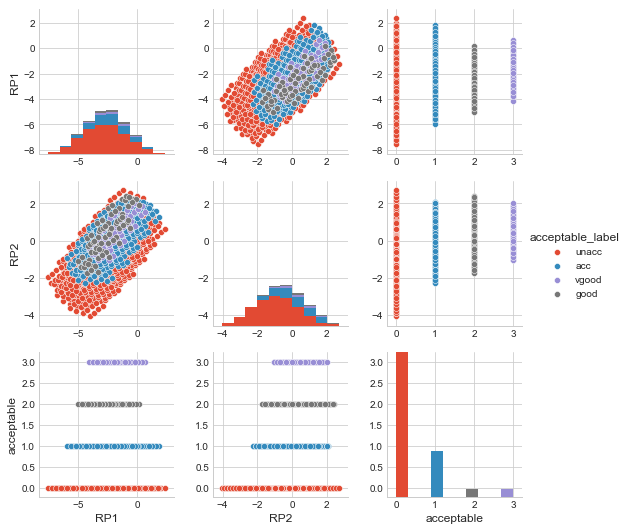

In [104]:
sns.set_style('whitegrid')
sns.pairplot(data_RP_df.iloc[:,[0,1,2,3]], hue='acceptable_label')
plt.show()

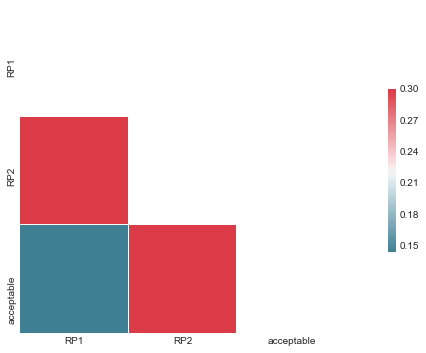

In [105]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,6))
mask = np.zeros_like(d_corr_RP1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(d_corr_RP1,mask=mask, cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

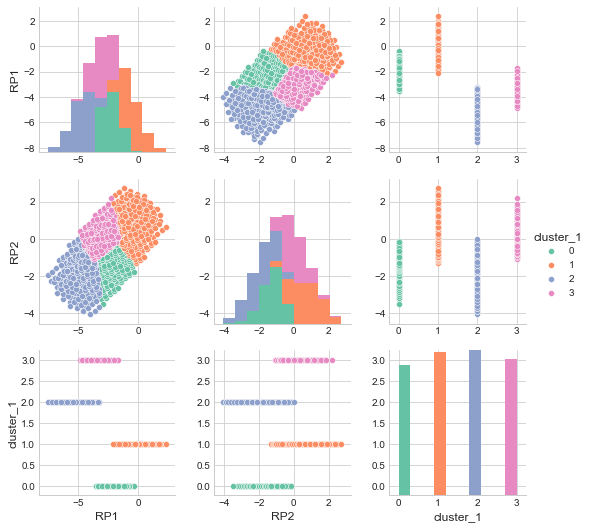

In [106]:
#K=4 K-means
kmeans_model_1 = KMeans(n_clusters=4,random_state=123)
distances_1 = kmeans_model_1.fit_transform(data_RP_df.iloc[:,0:2])
labels_1 = kmeans_model_1.labels_
data_RP_df['cluster_1']=labels_1
with sns.color_palette("Set2", 10):
    sns.pairplot(data_RP_df.iloc[:,[0,1,4]], hue='cluster_1')

In [107]:
#statistics of acceptable_label cluster_1 vs species
tb1 = pd.crosstab(data_RP_df['acceptable_label'],labels_1)
tb1

col_0,0,1,2,3
acceptable_label,,,,
acc,68,139,55,122
good,2,23,11,33
unacc,329,256,386,239
vgood,7,28,0,30


In [108]:
#cluster_1_label
def cluster_1_label(alpha):
    label_max = max(tb1.iloc[i,alpha] for i in range(4))
    if tb1.iloc[0,alpha] == label_max:
        return 'acc'
    if tb1.iloc[1,alpha] == label_max:
        return 'good'
    if tb1.iloc[2,alpha] == label_max:
        return 'unacc'
    if tb1.iloc[3,alpha] == label_max:
        return 'vgood'
data_RP_df['cluster_1_label']=data_RP_df['cluster_1'].apply(cluster_1_label)
data_RP_df.head()

,RP1,RP2,acceptable,acceptable_label,cluster_1,cluster_1_label
0,-2.335818,-0.959451,0,unacc,0,unacc
1,-1.055587,-0.092851,0,unacc,1,unacc
2,0.224645,0.773749,0,unacc,1,unacc
3,-1.811768,-1.304161,0,unacc,0,unacc
4,-0.531536,-0.437561,0,unacc,1,unacc


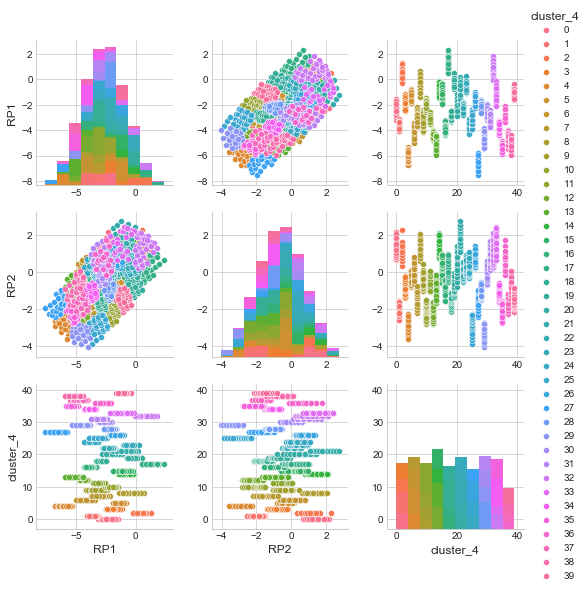

In [109]:
#K=40
kmeans_model_4 = KMeans(n_clusters=40,random_state=123)
distances_4 = kmeans_model_4.fit_transform(data_RP_df.iloc[:,0:3])
labels_4 = kmeans_model_4.labels_
data_RP_df['cluster_4']=labels_4
with sns.color_palette("Set2", 10):
    sns.pairplot(data_RP_df.iloc[:,[0,1,6]], hue='cluster_4')

In [110]:
#compare labels K=40
tb4 = pd.crosstab(data_RP_df['acceptable_label'],labels_4)
tb4

col_0,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
acceptable_label,,,,,,,,,,,,,,,,,,,,,
acc,38,0,0,40,0,0,0,29,0,0,...,45,0,38,0,0,0,0,19,23,1
good,0,0,0,1,0,0,0,1,1,14,...,0,0,0,21,0,0,16,4,2,0
unacc,4,53,36,0,37,69,52,0,0,0,...,0,37,0,0,72,51,0,0,0,41
vgood,0,0,0,0,0,0,0,0,18,20,...,0,0,0,1,0,0,0,0,0,0


In [111]:
#cluster_4_label
def cluster_4_label(alpha):
    label_max = max(tb4.iloc[i,alpha] for i in range(4))
    if tb4.iloc[0,alpha] == label_max:
        return 'acc'
    if tb4.iloc[1,alpha] == label_max:
        return 'good'
    if tb4.iloc[2,alpha] == label_max:
        return 'unacc'
    if tb4.iloc[3,alpha] == label_max:
        return 'vgood'
data_RP_df['cluster_4_label']=data_RP_df['cluster_4'].apply(cluster_4_label)
data_RP_df.head()

,RP1,RP2,acceptable,acceptable_label,cluster_1,cluster_1_label,cluster_4,cluster_4_label
0,-2.335818,-0.959451,0,unacc,0,unacc,28,unacc
1,-1.055587,-0.092851,0,unacc,1,unacc,5,unacc
2,0.224645,0.773749,0,unacc,1,unacc,2,unacc
3,-1.811768,-1.304161,0,unacc,0,unacc,28,unacc
4,-0.531536,-0.437561,0,unacc,1,unacc,19,unacc


In [112]:
#find center of K=4
centroids_RP1 = kmeans_model_1.cluster_centers_
print (centroids_RP1)

[[-2.26515359 -1.29405407]
 [-0.54378732  0.69995998]
 [-4.75478559 -1.90805602]
 [-3.01578974  0.05602183]]


In [113]:
#find center of K=40
centroids_RP4 = kmeans_model_4.cluster_centers_

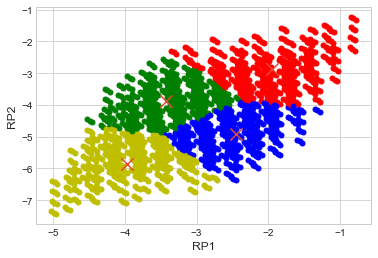

In [55]:
#RP K=4, upon cluster_1
colors = ["g.", "r.", "b.", "y."]
for i in range(len(data_RP_df)):
    plt.plot(data_RP_df.iloc[i,0],data_RP_df.iloc[i,1], colors[data_RP_df.iloc[i,4]], markersize = 10)    
plt.scatter(centroids_RP1[:,0], centroids_RP1[:,1],marker="x", s=150, linewidths =5, zorder=10)
plt.xlabel('RP1')
plt.ylabel('RP2')
plt.show()


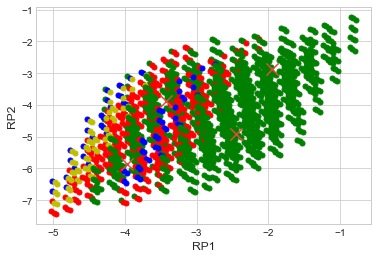

In [56]:
#RP K=4 upon original label
colors = ["g.", "r.", "b.", "y."]
for i in range(len(data_RP_df)):
    plt.plot(data_RP_df.iloc[i,0],data_RP_df.iloc[i,1], colors[data_RP_df.iloc[i,2]], markersize = 10)    
plt.scatter(centroids_RP1[:,0], centroids_RP1[:,1],marker="x", s=150, linewidths =5, zorder=10)
plt.xlabel('RP1')
plt.ylabel('RP2')
plt.show()


In [114]:
data_RP_df.head()

,RP1,RP2,acceptable,acceptable_label,cluster_1,cluster_1_label,cluster_4,cluster_4_label
0,-2.335818,-0.959451,0,unacc,0,unacc,28,unacc
1,-1.055587,-0.092851,0,unacc,1,unacc,5,unacc
2,0.224645,0.773749,0,unacc,1,unacc,2,unacc
3,-1.811768,-1.304161,0,unacc,0,unacc,28,unacc
4,-0.531536,-0.437561,0,unacc,1,unacc,19,unacc


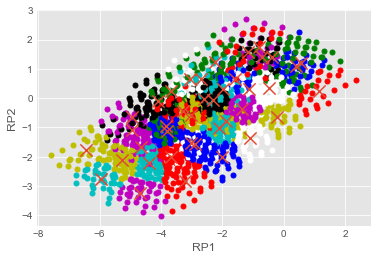

In [115]:
#RP K=40 upon cluster_4
style.use("ggplot")
colors = ["g.", "r.", "b.", "y.", "c.", "m.", "k.", "w.",
          "g.", "r.", "b.", "y.", "c.", "m.", "k.", "w.",
          "g.", "r.", "b.", "y.", "c.", "m.", "k.", "w.",
          "g.", "r.", "b.", "y.", "c.", "m.", "k.", "w.",
          "g.", "r.", "b.", "y.", "c.", "m.", "k.", "w."]
for i in range(len(data_RP_df)):
    plt.plot(data_RP_df.iloc[i,0],data_RP_df.iloc[i,1], colors[data_RP_df.iloc[i,6]], markersize = 10)    
plt.scatter(centroids_RP4[:,0], centroids_RP4[:,1],marker="x", s=150, linewidths =5, zorder=10)
plt.xlabel('RP1')
plt.ylabel('RP2')
plt.show()

In [116]:
d_corr_RP1=data_RP_df.iloc[:,[0,1,4]].corr()
d_corr_RP1
#Correlation K=4 for dataset after RP

,RP1,RP2,cluster_1
RP1,1.000000,0.626035,-0.430372
RP2,0.626035,1.000000,0.105498
cluster_1,-0.430372,0.105498,1.000000


In [117]:
d_corr_RP4=data_RP_df.iloc[:,[0,1,6]].corr()
d_corr_RP4
#lug_boot and persons

,RP1,RP2,cluster_4
RP1,1.000000,0.626035,-0.064642
RP2,0.626035,1.000000,-0.036670
cluster_4,-0.064642,-0.036670,1.000000


In [118]:
cluster_1_accuracy = len(data_RP_df[data_RP_df['acceptable_label']==data_RP_df['cluster_1_label']])/len(data_RP_df)
cluster_4_accuracy = len(data_RP_df[data_RP_df['acceptable_label']==data_RP_df['cluster_4_label']])/len(data_RP_df)
print('K=4 KMeans -> {0:.4f}%'.format(cluster_1_accuracy*100))
print('K=40 KMeans -> {0:.4f}%'.format(cluster_4_accuracy*100))

K=4 KMeans -> 70.0231%
K=40 KMeans -> 97.6273%


In [119]:
data_RP_df.describe()

,RP1,RP2,acceptable,cluster_1,cluster_4
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,-2.654832,-0.608378,0.414931,1.517361,18.836806
std,1.727883,1.264437,0.740700,1.100476,11.187096
min,-7.568723,-4.038186,0.000000,0.000000,0.000000
25%,-3.870865,-1.509361,0.000000,1.000000,10.000000
50%,-2.646921,-0.608152,0.000000,2.000000,18.000000
75%,-1.447918,0.293407,1.000000,2.000000,28.000000
max,2.346367,2.715858,3.000000,3.000000,39.000000


In [120]:
data_RP_KM_NN_df = pd.DataFrame(data=data_RP[0:,0:],
                   columns=['RP1','RP2'])
data_RP_KM_NN_df['K40_label'] = data_RP_df['cluster_4']
data_RP_KM_NN_df.to_csv('data_RP_KM.csv' , sep=',')